In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set("talk", style="ticks")

from astropy.io import fits

from tqdm import tqdm

from pyFIT3D.modelling.stellar import SSPModels
from pyFIT3D.common.auto_ssp_tools import auto_ssp_elines_single_main
from lvmdap.modelling.synthesis import StellarSynthesis
from lvmdap.analysis.plotting import *

import warnings
warnings.filterwarnings("ignore")

import contextlib
import sys

class DummyFile(object):
    def write(self, x): pass

@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = DummyFile()
    yield
    sys.stdout = save_stdout

In [2]:
MASTAR_PATH = "/disk-a/mejia/Research/UNAM/mastar-checks/notebooks/fitting/_data/classified-mastar-v3.1.2-cleaned-v2-gsl"
ZSUN = 0.017

In [3]:
mastar_fits = sorted(os.path.join(root,file) for root, subs, files in os.walk(MASTAR_PATH) for file in files if file.endswith(".fits.gz"))

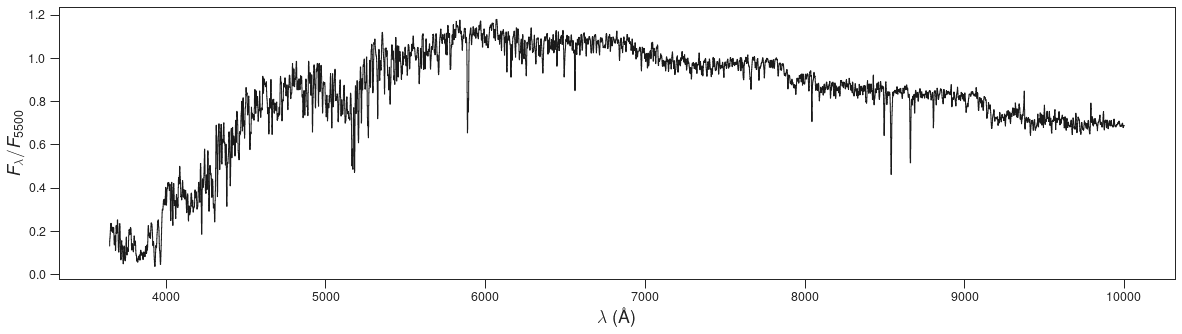

In [4]:
star = fits.open(mastar_fits[-2])
# star.info()

plt.figure(figsize=(20,5))
plt.step(star["SPECTRA"].data["WAVELENGTH"], star["SPECTRA"].data["FLUX"], "k", lw=1)
plt.xlabel("$\lambda$ (\AA)")
plt.ylabel(r"$F_\lambda/F_{5500}$");

In [5]:
# See the similar script to run the analysis with intrumental dispersion: 
#      bin/auto_ssp_elines_rnd_sigma_inst.py
#

# using the initial values:
#
# Instrumental dispersion: 2.5 AA
sigma_inst = 0.001

# Masks:
#     File with list of ranges of wavelength to be masked in whole analysis
mask_list = None#"../../_fitting-data/_configs/mask_elines.txt"

######################
######################
# Non linear analysis: (redshift, observed dispersion and dust attenuation)
#     wavelength range: 
#         [3850, 4700] AA for the redshift and sigma analysis
#         [3800, 7000] AA for the dust attenuation
w_min_max = [3650, 10000]
nl_w_min_max = [3850, 4700]

#     models:
#         Miles solar 3 models
ssp_nl_fit_file = "../../_fitting-data/_basis_mastar_v2/stellar-basis-spectra-5.fits.gz"

#     emission lines to be masked:
elines_mask_file = "../../_fitting-data/_configs/MaNGA/emission_lines_long_list.txt"

#     redshift:
#         initial value: 0.02449
#                 delta: 0.0001
#                   min: 0.02349
#                   max: 0.02549
redshift_set = [0,0,0,0]

#     dispersion: (km/s)
#         initial value: 30
#                 delta: 20
#                   min: 1
#                   max: 150
sigma_set = [0,0,0,0]

#     dust attenuation at V band (mag):
#         initial value: 0.3
#                 delta: 0.15
#                   min: 0
#                   max: 1.6
AV_set = [0,0,0,0]

# SSP analysis:
#     wavelength range: 
#         [3800, 7000] AA
#
#     models:
#         GSD01 156 models
ssp_file = "../../_fitting-data/_basis_mastar_v2/stellar-basis-spectra-100.fits.gz"
par_file = "../../_fitting-data/_basis_mastar_v2/stellar-basis-params-100.fits.gz"

#     configuration file:
config_file = "../../_fitting-data/_configs/auto_ssp_V500_several_Hb.config"

# plot options
stellar_param = fits.open(par_file)

labels = {"TEFF":r"$\log{T_\text{eff}}$", "LOGG":r"$\log{g}$", "MET":r"$[\text{Fe}/\text{H}]$", "ALPHAM":r"$[\alpha/\text{Fe}]$"}
cmap = "binary_r"
color = sns.color_palette(cmap)[0]

In [7]:
experiment = "stars"
obs_path = f"_data/{experiment}/obs/"
out_path = f"_data/{experiment}/out/"
fig_path = f"_data/{experiment}/figs/"
os.makedirs(obs_path, exist_ok=True)
os.makedirs(out_path, exist_ok=True)
os.makedirs(fig_path, exist_ok=True)


true_param_table = []
for mastar_fits_file in tqdm(mastar_fits, desc="writing spectra", ascii=True, unit="SED"):
    star = fits.open(mastar_fits_file)
    params = {card: np.round(star[0].header[card],2) for card in labels.keys()}
    
    out_file = f"mastar-{params['TEFF']}-{params['LOGG']}-{params['MET']}-{params['ALPHAM']}-sed".replace(".","p") + ".txt"
    sed_path = os.path.join(obs_path,out_file)
    if not os.path.isfile(sed_path):
        np.savetxt(sed_path, np.column_stack((
            np.arange(star["SPECTRA"].header["NAXIS2"], dtype=int),
            star["SPECTRA"].data["WAVELENGTH"],
            star["SPECTRA"].data["FLUX"],
            star["SPECTRA"].data["FLUX"]*0.05
        )))
    star.close()

    true_param_table.append([
        out_file,
        os.path.basename(mastar_fits_file),
    ]+list(params.values()))

true_param_table = pd.DataFrame(data=true_param_table, columns="sed_file mastar_file TEFF LOGG MET ALPHAM".split())
true_param_table.TEFF = np.log10(true_param_table.TEFF)
true_path = os.path.join(f"_data/{experiment}", f"true-{experiment}-params.csv")
if not os.path.isfile(true_path):
    true_param_table.to_csv(true_path, index=False)

writing spectra: 100%|##########################################################################################################################| 20332/20332 [00:22<00:00, 897.90SED/s]


In [9]:
import subprocess


for idx, row in tqdm(true_param_table.iterrows(), total=len(true_param_table), desc=f"fitting {experiment}", ascii=True, unit="SED"):
    label = row.sed_file.replace("-sed.txt", "")
    if os.path.isfile(os.path.join(out_path,label)): continue
    subprocess.run(f"lvm-dap {os.path.join(obs_path,row.sed_file)} {ssp_file} {sigma_inst} {label} --rsp-nl-file {ssp_nl_fit_file} --w-range {' '.join(map(str,w_min_max))} --w-range-nl {' '.join(map(str,nl_w_min_max))} --redshift {' '.join(map(str,redshift_set))} --sigma {' '.join(map(str,sigma_set))} --AV {' '.join(map(str,AV_set))} -c --ignore-gas --config-file {config_file} --output-path {out_path}".split(), capture_output=True)

fitting stars: 100%|##########################################################################################################################| 20332/20332 [00:01<00:00, 12670.91SED/s]


In [ ]:
for idx, row in tqdm(true_param_table.iterrows(), total=len(true_param_table), desc="plotting results", ascii=True, unit="SED"):
    label = row.sed_file.replace("-sed.txt", "")
    
    fig_file = os.path.join(fig_path, f"{label}.png")
    if not os.path.isfile(fig_file):
        coeffs = pd.read_csv(os.path.join(out_path,f"coeffs_{label}"), sep="\s+")
        coeffs.columns = coeffs.columns[1:].tolist()+["#"]
        coeffs.drop(columns="#", inplace=True)

        f = fits.open(os.path.join(out_path,f"output.{label}.fits.gz"), memmap=False)

        fig, ax0, axs = plot_dap_fit(
            f[0],
            coeffs.COEFF.values,
            stellar_param,
            labels, cmap, color, row.values[2:]
        )
        fig.savefig(fig_file, bbox_inches="tight")
        plt.close(fig)
        f.close()

In [11]:
LIGHT_COLOR = "#E3DEDE"
MED_COLOR = "#8284A5"
MASTAR_COLOR = "#574E6C"
MASTAR_CMAP = sns.color_palette(f"blend:{LIGHT_COLOR},{MASTAR_COLOR}")
QUARTILE_PALETTE = sns.color_palette(f"blend:{LIGHT_COLOR},{MASTAR_COLOR}", n_colors=3)


def build_comparison_table(tablea, tableb, labela, labelb, columns, delta_prefix=r"$\Delta$"):
    tablea_ = tablea.filter(items=columns)
    tableb_ = tableb.filter(items=columns)

    comparison = pd.merge(tablea_.add_suffix(f" {labela}"), tableb_.add_suffix(f" {labelb}"), left_index=True, right_index=True, how="inner")
    residuals = comparison.filter(like=labela).rename(columns=lambda s: s.replace(f" {labela}",""))-comparison.filter(like=labelb).rename(columns=lambda s: s.replace(f" {labelb}",""))
    residuals = residuals.add_prefix(delta_prefix)

    comparison = pd.concat((comparison,residuals), axis="columns")
    return comparison

def consistency_plot(comparison_table, column, unit, is_logscale, labelx, labely, lims=None, filled_levels=(0.25,0.50,0.75,1.00), dashed_levels=(0.05,), filled_palette=QUARTILE_PALETTE, dashed_color=LIGHT_COLOR, guide_color="w", margins_color=MASTAR_COLOR):

    summary = comparison_table.describe(percentiles=(0.01,0.99))

    if lims is None:
        rangea = summary.loc[["1%","99%"],f"{column} {labelx}"].values
        rangeb = summary.loc[["1%","99%"],f"{column} {labely}"].values
        xrange = np.array([min(*rangea, *rangeb), max(*rangea, *rangeb)])
    else:
        xrange = lims[:2]
    mu_a, sigma_a = summary.loc[["mean","std"],f"{column} {labelx}"].values
    mu_b, sigma_b = summary.loc[["mean","std"],f"{column} {labely}"].values

    g = sns.jointplot(data=comparison_table, x=f"{column} {labelx}", y=f"{column} {labely}", kind="kde", dropna=True, height=7,
                      levels=filled_levels, marginal_kws=dict(alpha=1.0, color=margins_color),
                      joint_kws=dict(colors=filled_palette), fill=True, xlim=xrange, ylim=xrange)

    g.ax_joint.plot(xrange, xrange, "-", lw=1, color=guide_color)
    if is_logscale:
        xscale = np.log10(np.linspace(*(10**xrange)))
        g.ax_joint.plot(xscale, np.log10(10**xscale * 1.1), "--", lw=0.7, color=guide_color)
        g.ax_joint.plot(xscale, np.log10(10**xscale / 1.1), "--", lw=0.7, color=guide_color)
    else:
        g.ax_joint.plot(xrange, xrange+np.abs(0.1*xrange), "--", lw=0.7, color=guide_color)
        g.ax_joint.plot(xrange, xrange-np.abs(0.1*xrange), "--", lw=0.7, color=guide_color)

    g.ax_marg_x.axvline(mu_a, ls="-", lw=0.7, color=guide_color)
    g.ax_marg_x.axvline(mu_a-sigma_a, ls="--", lw=0.7, color=guide_color)
    g.ax_marg_x.axvline(mu_a+sigma_a, ls="--", lw=0.7, color=guide_color)
    g.ax_marg_y.axhline(mu_b, ls="-", lw=0.7, color=guide_color)
    g.ax_marg_y.axhline(mu_b-sigma_b, ls="--", lw=0.7, color=guide_color)
    g.ax_marg_y.axhline(mu_b+sigma_b, ls="--", lw=0.7, color=guide_color)

    g.ax_joint.text(0.95, 0.10, f"{labelx} $\mu,\sigma={mu_a:.2f},{sigma_a:.2f}\,${unit}", ha="right", size="small", transform=g.ax_joint.transAxes)
    g.ax_joint.text(0.95, 0.05, f"{labely} $\mu,\sigma={mu_b:.2f},{sigma_b:.2f}\,${unit}", ha="right", size="small", transform=g.ax_joint.transAxes)

    sns.kdeplot(data=comparison_table, x=f"{column} {labelx}", y=f"{column} {labely}", levels=dashed_levels, color=dashed_color, linestyles="--", linewidths=1.5, ax=g.ax_joint)

    return g

In [12]:
model_param_table = []
for idx, row in tqdm(true_param_table.iterrows(), total=len(true_param_table), desc="plotting results", ascii=True, unit="SED"):
    label = row.sed_file.replace("-sed.txt", "")
    
    fig_file = os.path.join(fig_path, f"{label}.png")
    model = pd.read_csv(os.path.join(out_path,f"coeffs_{label}"), sep="\s+")
    model.columns = model.columns[1:].tolist()+["#"]
    model.drop(columns="#", inplace=True)

    weights = model.COEFF/model.COEFF.sum()
    model_param_table.append([
        (weights*model.TEFF).sum(),
        (weights*model.LOGG).sum(),
        (weights*model.META).sum(),
        (weights*model.ALPHAM).sum()
    ])

model_param_table = pd.DataFrame(data=model_param_table, columns="TEFF LOGG MET ALPHAM".split())

plotting results: 100%|#########################################################################################################################| 20332/20332 [01:12<00:00, 282.31SED/s]


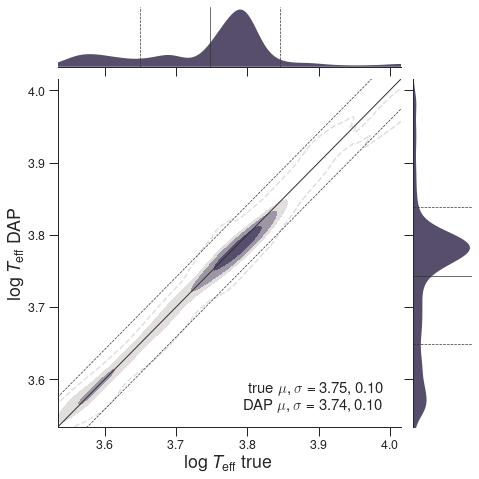

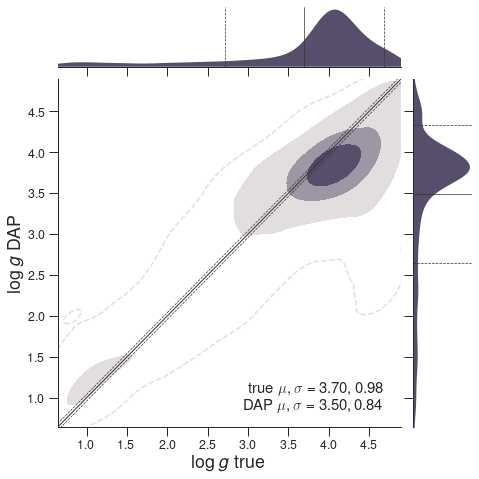

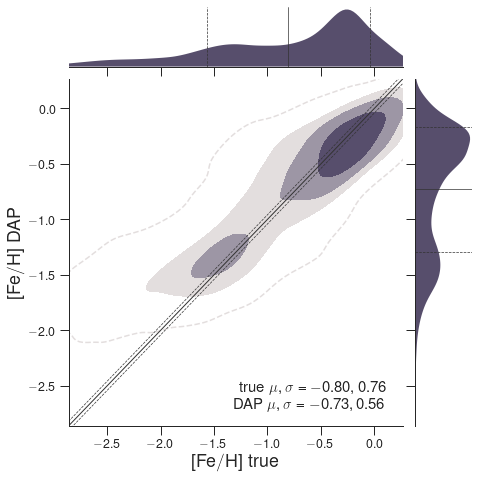

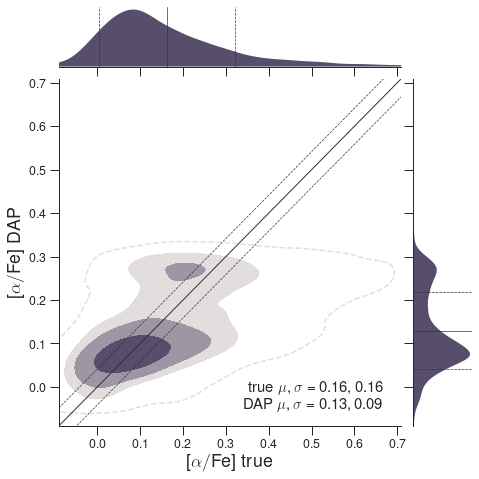

In [13]:
comparison_table = build_comparison_table(
    tablea=model_param_table.rename(columns=labels),
    tableb=true_param_table.rename(columns=labels),
    labela="DAP",
    labelb="true",
    columns=labels.values()
)
g = consistency_plot(
    comparison_table=comparison_table,
    column=list(labels.values())[0], unit="", is_logscale=True,
    labelx="true", labely="DAP", guide_color="0.2"
)
g.fig.savefig(os.path.join(fig_path, f"rsp-{experiment}-teff.png"), bbox_inches="tight")

g = consistency_plot(
    comparison_table=comparison_table,
    column=list(labels.values())[1], unit="", is_logscale=True,
    labelx="true", labely="DAP", guide_color="0.2"
)
g.fig.savefig(os.path.join(fig_path, f"rsp-{experiment}-logg.png"), bbox_inches="tight")

g = consistency_plot(
    comparison_table=comparison_table,
    column=list(labels.values())[2], unit="", is_logscale=True,
    labelx="true", labely="DAP", guide_color="0.2"
)
g.fig.savefig(os.path.join(fig_path, f"rsp-{experiment}-met.png"), bbox_inches="tight")

g = consistency_plot(
    comparison_table=comparison_table,
    column=list(labels.values())[3], unit="", is_logscale=True,
    labelx="true", labely="DAP", guide_color="0.2"
)
g.fig.savefig(os.path.join(fig_path, f"rsp-{experiment}-alpham.png"), bbox_inches="tight")

In [ ]:
# TODO: stablish a physical connection between the output stellar spectrum (ionizing flux) and the nebular emission
#   - feed Teff and iron to stellar model and evaluate the ionizing flux as compared to the observed one